In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("..")

import torch.nn as nn
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from datasets import SineDataset, SineCosineDataset, CosineDataset
from tiny.utils import plot_point_cloud, plot_point_clouds, count_parameters
from tiny import Diffusion, PointCloudDDPM, PointCloudDiffusionTrainer, UnconditionalPointCloudDiT
from tiny.model import PointDiffusionTransformer
from torch.utils.data import ConcatDataset

In [3]:
num_points = 32
# dataset = SineCosineDataset(num_points=num_points, size=1024)
sine_dataset = SineDataset(num_points=num_points, size=15000)
cosine_dataset = CosineDataset(num_points=num_points, size=15000)
dataset = sine_dataset
dataset = cosine_dataset
dataset = ConcatDataset([sine_dataset, cosine_dataset])

dataloader = DataLoader(dataset, collate_fn=sine_dataset.collate, batch_size=128, shuffle=True)

In [14]:
diffusion = Diffusion(schedule_type="linear", num_timesteps=1000, learn_sigma=False)
# dit = UnconditionalPointCloudDiT(input_size=num_points, in_channels=2, depth=1, num_heads=1, hidden_size=128).to("cuda")
# dit = PointDiffusionTransformer(input_channels=2, 
#                                 output_channels=2,
#                                 n_ctx=num_points,
#                                 heads=1,
#                                 width=128,
#                                 device="cuda",
#                                 layers=1,
#                                 dtype=torch.float32,
#                                 )
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(2, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 2),
        )


    def forward(self, x, t):
        return self.mlp(x)


mlp = MLP()
# dit = MLP(hidden_size=128, hidden_layers=10, emb_size=128).to("cuda")
ddpm = PointCloudDDPM(mlp, diffusion)

In [15]:
count_parameters(mlp)

17154

In [16]:
trainer = PointCloudDiffusionTrainer(
    ddpm,
    dataloader,
    num_epochs=50,
    lr=1e-3,
    a=False
)

[INFO] Model Parameters: 17154


  0%|          | 36/11750 [00:00<21:46,  8.97it/s, loss=0.238]

100%|██████████| 11750/11750 [00:24<00:00, 482.48it/s, loss=0.176]


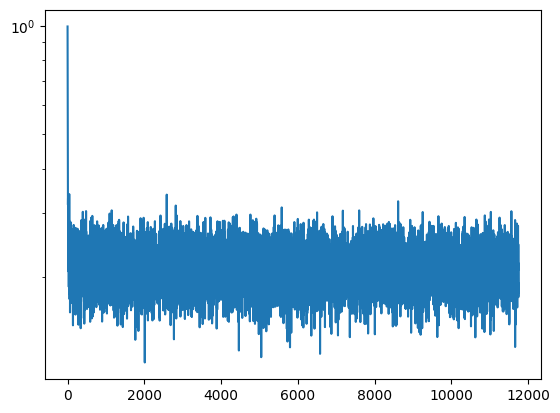

In [17]:
losses = trainer.train()
plt.semilogy(losses)

Sampling:  57%|█████▊    | 575/1000 [00:00<00:00, 2866.37it/s]

Sampling: 100%|██████████| 1000/1000 [00:00<00:00, 2859.29it/s]


torch.Size([100, 32, 2])


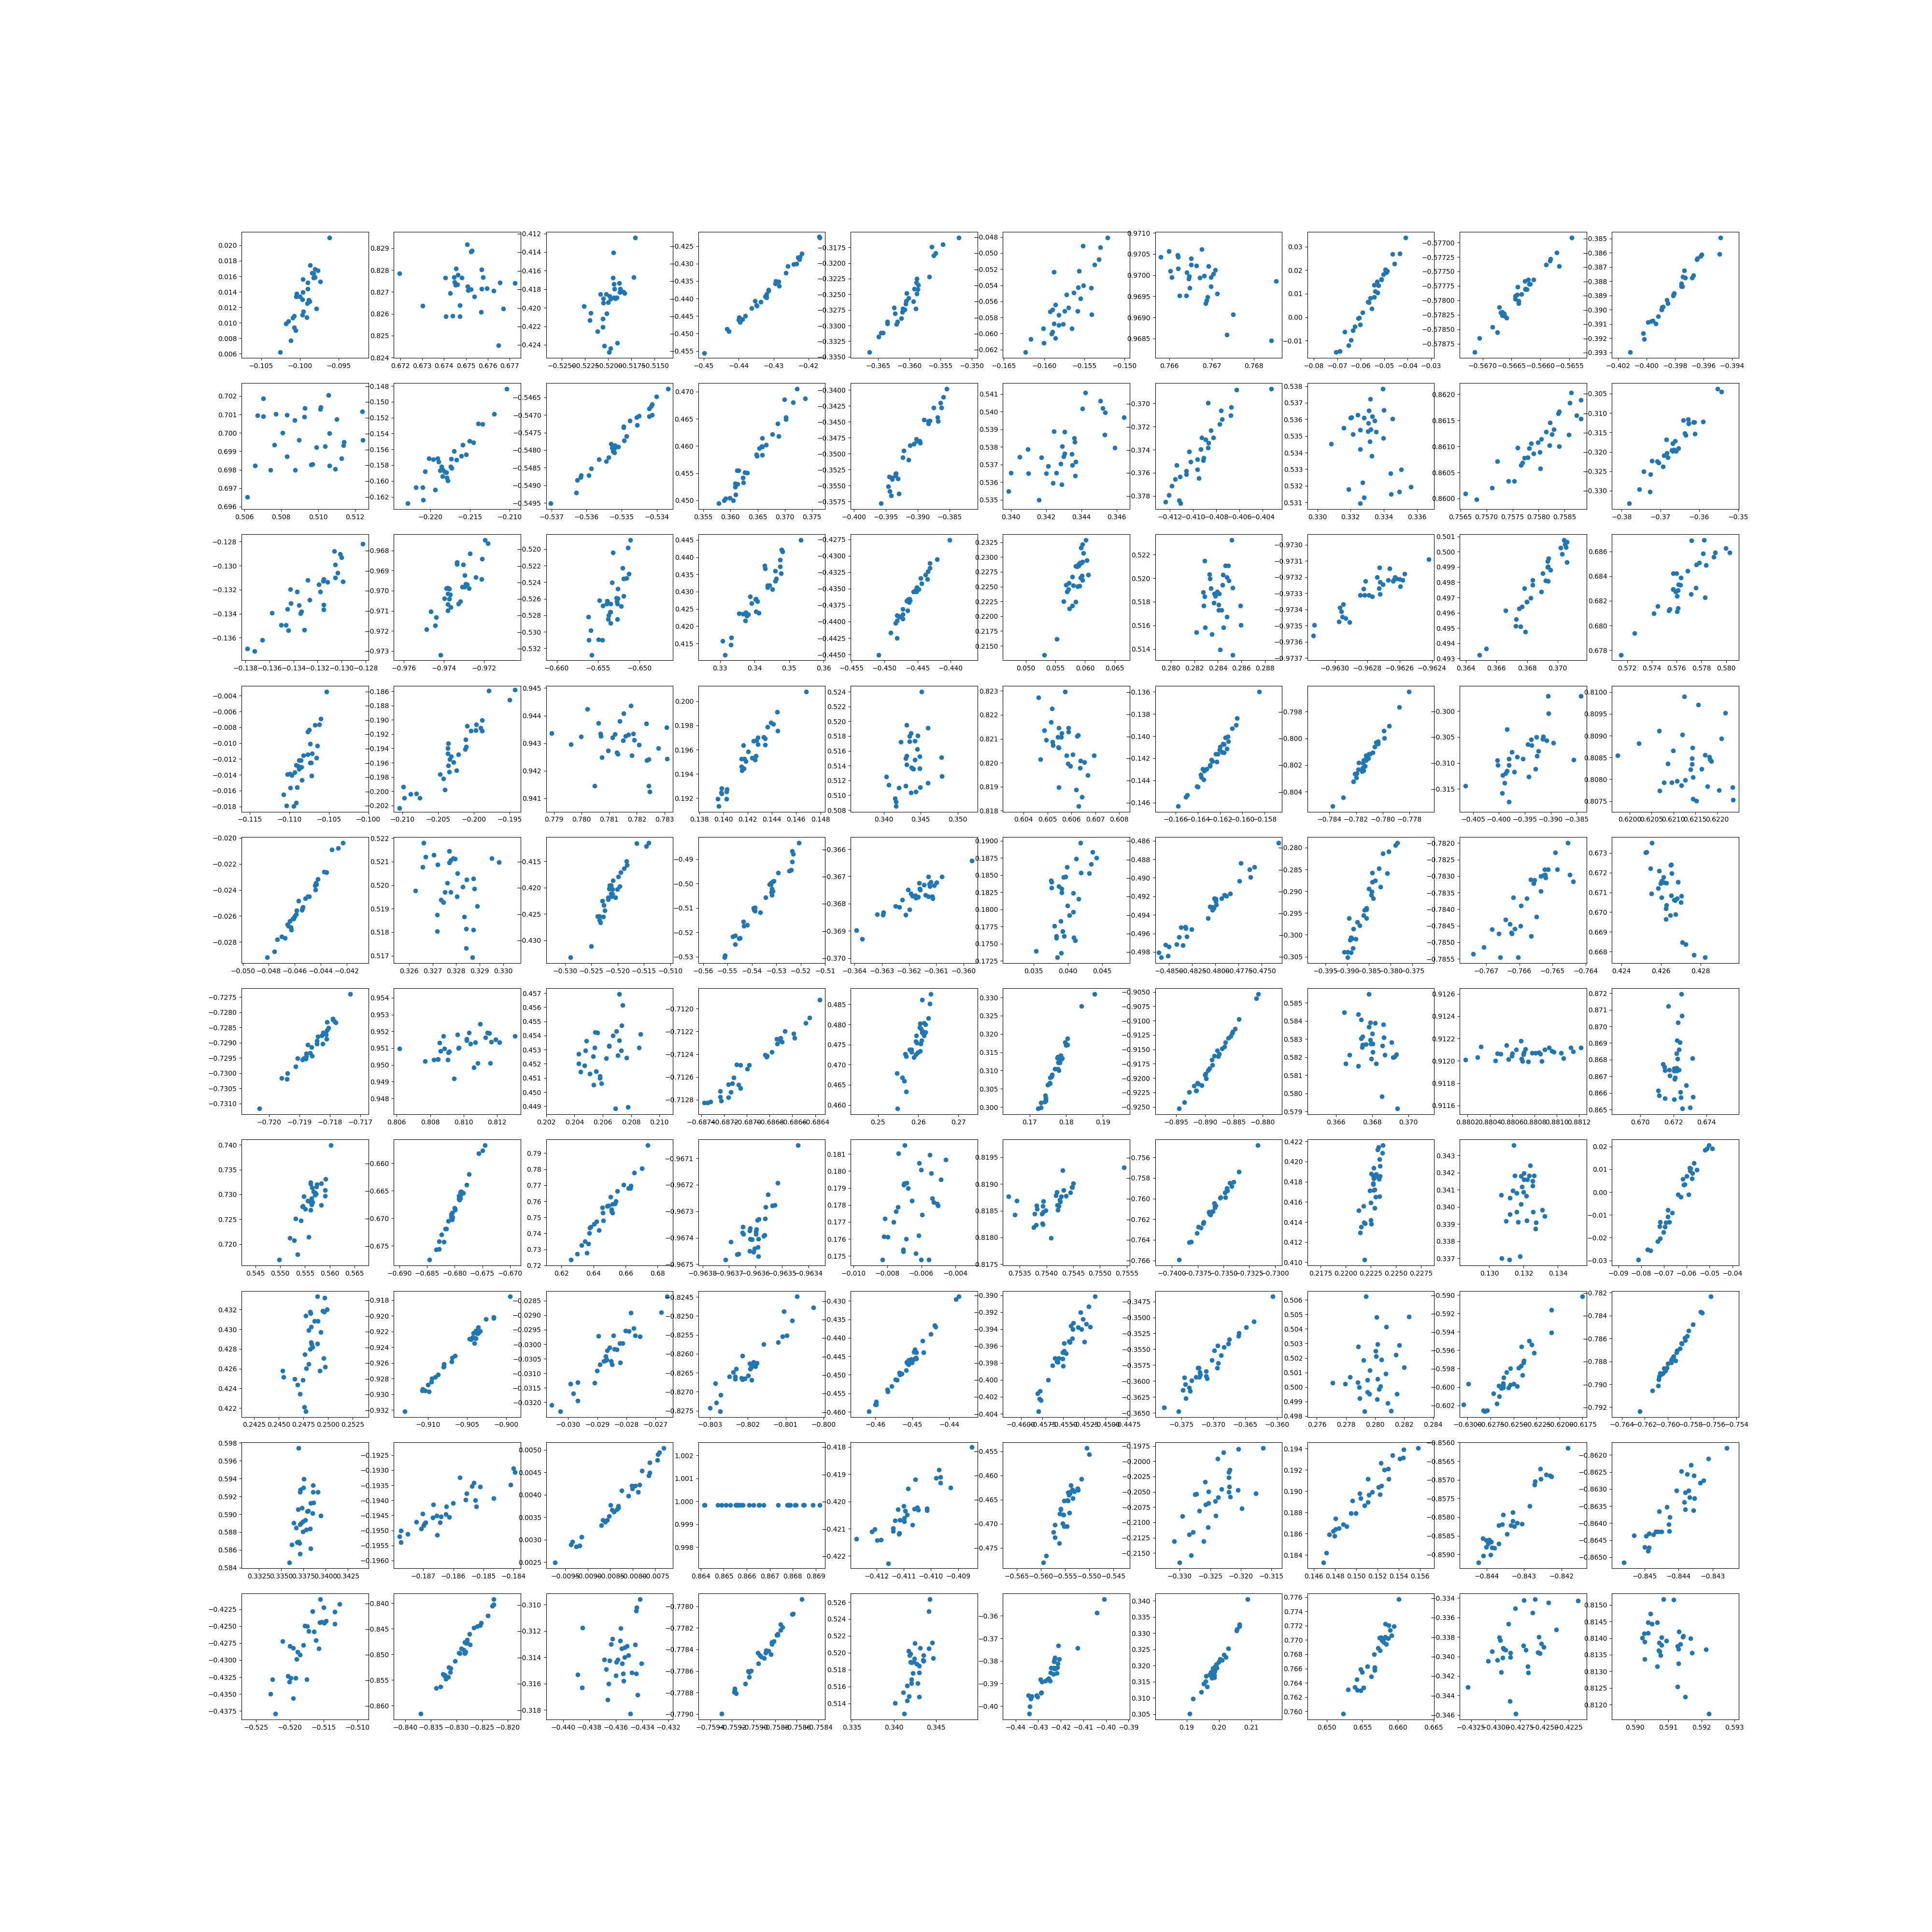

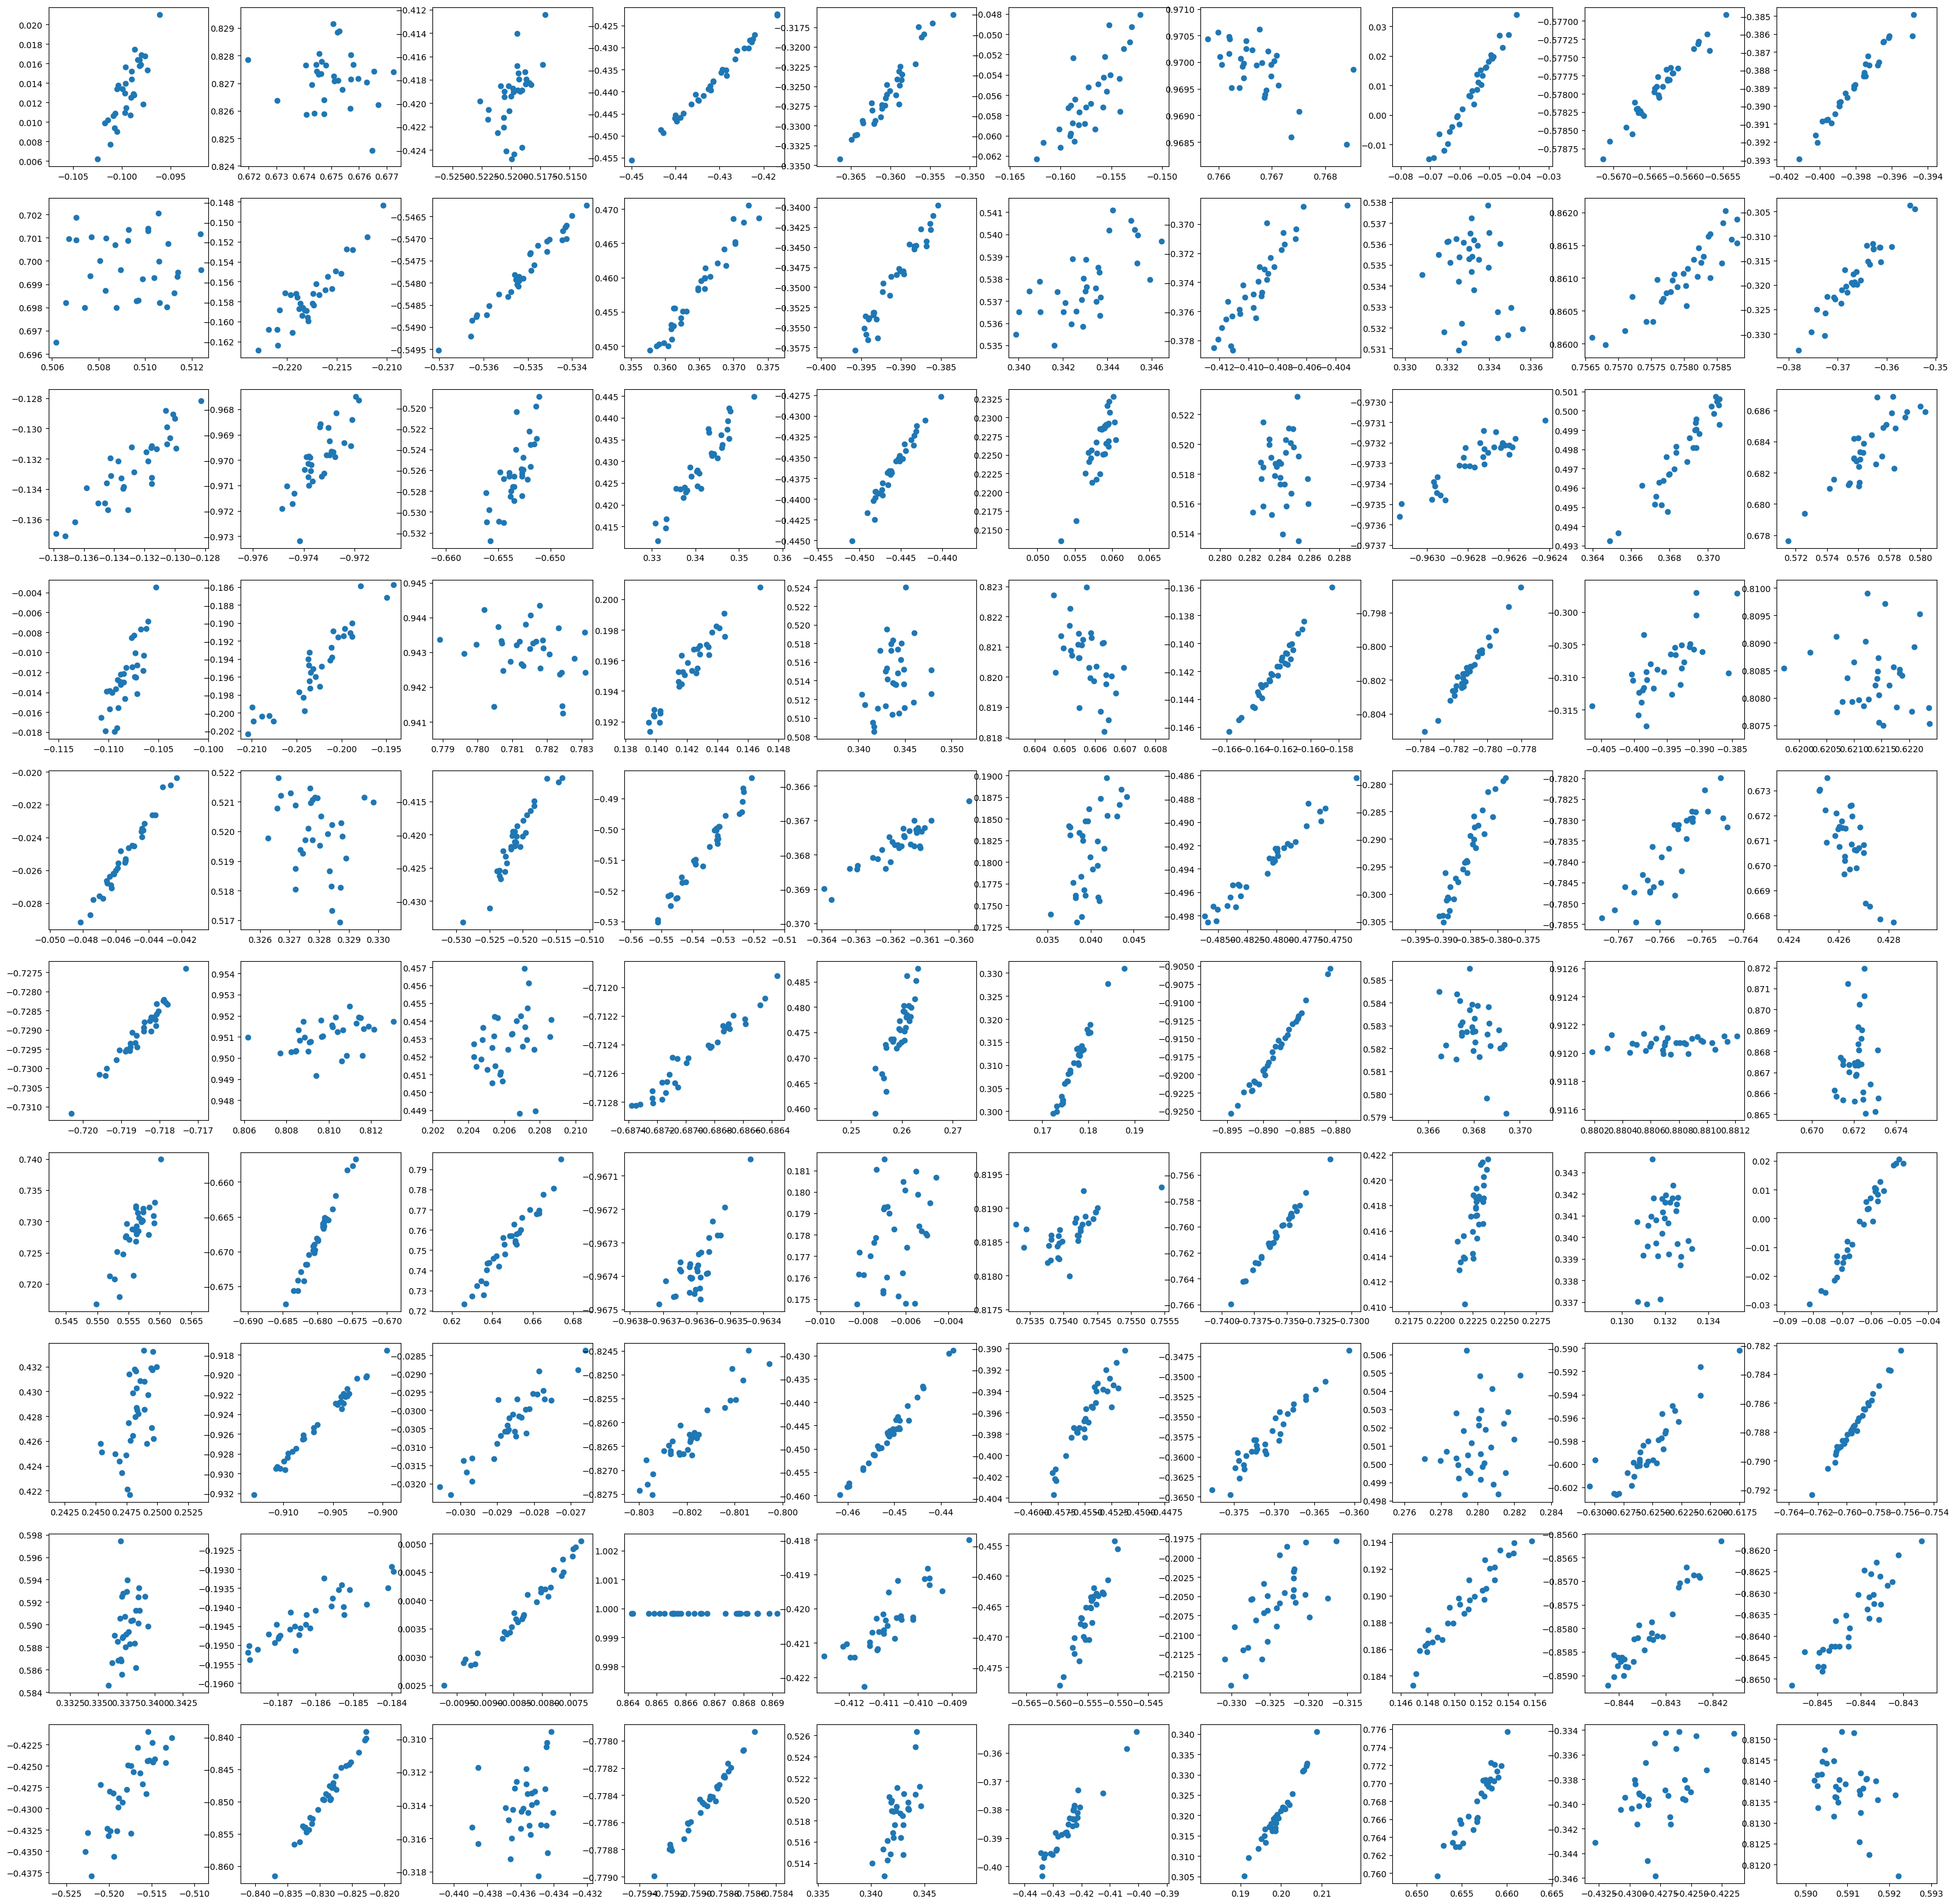

In [21]:
# sample = diffusion.p_sample_loop(mlp, (100, 2, num_points), clip_denoised=False)
sample = diffusion.p_sample_loop(mlp, (100, num_points, 2), clip_denoised=True)
print(sample.shape)
# sample = sample.permute(0, 2, 1)
plot_point_clouds(sample, 10, 10)

In [12]:
sample.shape

torch.Size([100, 2, 16])